Ressources :
- https://netcarbon.notion.site/Senior-Data-engineer-exercice-ee2f44d703804eb68a42bfb819b45dca
- https://www.agricolus.com/en/vegetation-indices-ndvi-ndmi/
- https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/
- https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

In [1]:
import numpy as np
%matplotlib inline

import pandas as pd
import geopandas as gpd
import contextily as cx
import rich.table
import math
import xarray as xr
from random import choice
from rasterio.features import geometry_mask
from matplotlib import pyplot as plt
from pystac_client import Client
from shapely import wkt
from odc.stac import stac_load

In [2]:
tournesol_df = pd.read_csv('../sampled_rpg_data/tournesol.csv')
maize_df = pd.read_csv('../sampled_rpg_data/maize.csv')
rpg_df = pd.concat([tournesol_df, maize_df])
rpg_df['geometry'] = rpg_df['geometry'].apply(wkt.loads)

In [3]:
rpg_gdf = gpd.GeoDataFrame(rpg_df, crs='epsg:2154').to_crs(crs='epsg:4326')
rpg_gdf.head()

,Unnamed: 0,ID_PARCEL_2022,SURF_PARC_2022,CODE_CULTU_2022,CODE_GROUP_2022,CULTURE_D1_2022,CULTURE_D2_2022,geometry,libelle_cultu_2022,CAMPAGNE_DEBUT_2022,CAMPAGNE_FIN_2022,libelle_d1_2022,libelle_d2_2022,area
0,187842,1133906,9.71,TRN,6,NaN,NaN,"POLYGON ((0.97091 43.54035, 0.97132 43.54032, ...",Tournesol,2015,NaN,NaN,NaN,97114.949260
1,139550,841881,3.76,TRN,6,NaN,NaN,"POLYGON ((1.97183 43.86112, 1.97183 43.86112, ...",Tournesol,2015,NaN,NaN,NaN,37550.814191
2,1564874,9453515,3.38,TRN,6,NaN,NaN,"POLYGON ((1.09581 43.7644, 1.09581 43.7644, 1....",Tournesol,2015,NaN,NaN,NaN,33768.372757
3,1036094,6261084,0.94,TRN,6,NaN,NaN,"POLYGON ((0.34178 43.29936, 0.34089 43.29935, ...",Tournesol,2015,NaN,NaN,NaN,9369.597735
4,1169290,7064460,0.58,TRN,6,NaN,NaN,"POLYGON ((0.32516 43.83757, 0.32468 43.83785, ...",Tournesol,2015,NaN,NaN,NaN,5755.995216


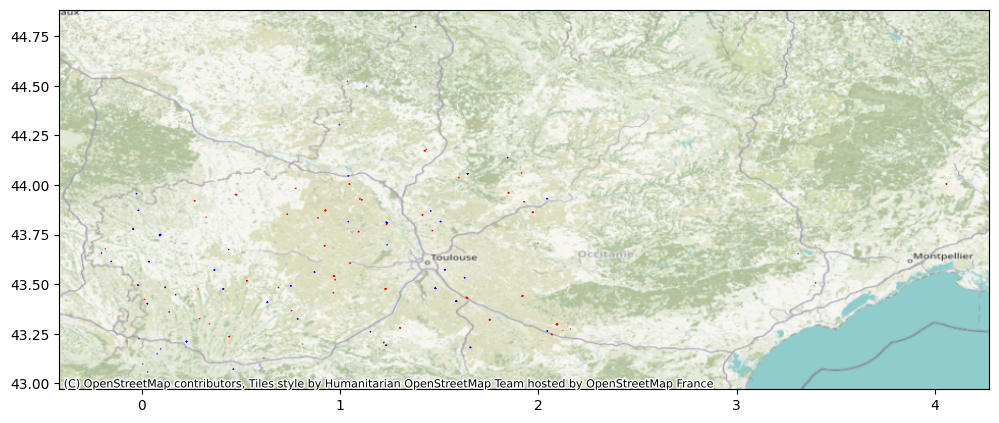

In [4]:
ax = rpg_gdf[rpg_gdf["CODE_CULTU_2022"] == "TRN"].plot(figsize=(12, 12), edgecolor='red')
rpg_gdf[rpg_gdf["CODE_CULTU_2022"] == "MIS"].plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax, crs=rpg_gdf.crs)

2.094641800785864 43.2966876157951


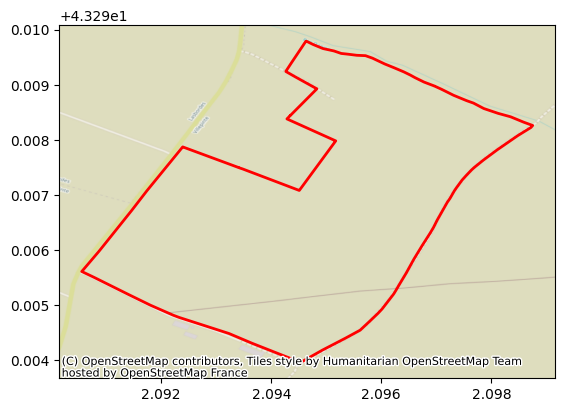

In [5]:
sample_idx = choice(rpg_gdf.index)
sample_poly = rpg_gdf.iloc[sample_idx]["geometry"]
sample_poly_gdf = gpd.GeoDataFrame({'geometry': [sample_poly]}, crs='epsg:4326')
print(sample_poly.centroid.x, sample_poly.centroid.y)

ax = sample_poly_gdf.plot(edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax, crs=rpg_gdf.crs)

In [6]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")

In [7]:
query = catalog.search(collections=["sentinel-2-l2a"], datetime="2023-01-01/2023-12-31", limit=100, intersects=sample_poly)

In [8]:
items = query.item_collection()
len(items)

261

In [9]:
sentinel_gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
sentinel_gdf.head()

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((1.76571 43.34619, 1.78522 42.35855, ...",2023-12-31T17:08:00.891Z,sentinel-2a,sentinel-2,[msi],84.118253,32631,31,T,DH,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:59:05.593000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/eee7...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:08:00.891Z
1,"POLYGON ((1.74703 44.24654, 1.76747 43.25906, ...",2023-12-31T17:10:50.488Z,sentinel-2a,sentinel-2,[msi],99.861979,32631,31,T,DJ,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:58:51.055000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/70b9...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:10:50.488Z
2,"POLYGON ((1.76571 43.34619, 1.78524 42.35765, ...",2023-12-28T17:05:14.628Z,sentinel-2a,sentinel-2,[msi],99.676591,32631,31,T,DH,...,S2A_OPER_MSI_L2A_DS_2APS_20231228T145252_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231228T145252_A0444...,1.033762,2023-12-28T10:49:09.455000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/342a...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-28T17:05:14.628Z
3,"POLYGON ((1.81594 44.24727, 1.75114 44.05189, ...",2023-12-28T16:59:44.627Z,sentinel-2a,sentinel-2,[msi],100.000000,32631,31,T,DJ,...,S2A_OPER_MSI_L2A_DS_2APS_20231228T145252_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231228T145252_A0444...,1.033762,2023-12-28T10:48:55.062000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/db3f...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-28T16:59:44.627Z
4,"POLYGON ((1.76571 43.34619, 1.78522 42.35855, ...",2023-12-26T14:40:58.824Z,sentinel-2b,sentinel-2,[msi],47.284961,32631,31,T,DH,...,S2B_OPER_MSI_L2A_DS_2BPS_20231226T123045_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20231226T123045_A0355...,1.033528,2023-12-26T10:59:10.009000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/5ce7...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-26T14:40:58.824Z


<Axes: >

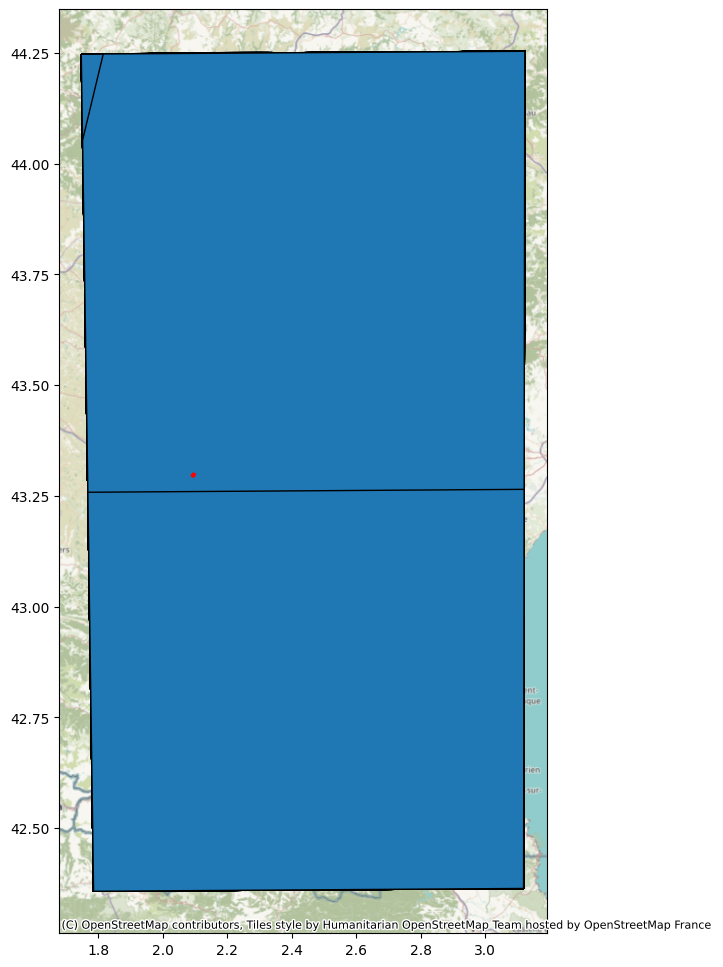

In [10]:
ax = sentinel_gdf.plot(edgecolor="k", figsize=(12, 12))
cx.add_basemap(ax=ax, crs=sentinel_gdf.crs)
sample_poly_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

In [11]:
sample_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in sample_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key         ┃ Description                     ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ aot               │ Aerosol optical thickness (AOT) │
│ blue              │ Blue (band 2) - 10m             │
│ coastal           │ Coastal aerosol (band 1) - 60m  │
│ granule_metadata  │                                 │
│ green             │ Green (band 3) - 10m            │
│ nir               │ NIR 1 (band 8) - 10m            │
│ nir08             │ NIR 2 (band 8A) - 20m           │
│ nir09             │ NIR 3 (band 9) - 60m            │
│ red               │ Red (band 4) - 10m              │
│ rededge1          │ Red edge 1 (band 5) - 20m       │
│ rededge2          │ Red edge 2 (band 6) - 20m       │
│ rededge3          │ Red edge 3 (band 7) - 20m       │
│ scl               │ Scene classification map (SCL)  │
│ swir16            │ SWIR 1 (band 11) - 20m          │
│ swir22            │ SWIR 2 (band 12) - 20m          │
│ thumbnail         │ Thumbnail image                 │
│ tileinfo_metadata │                                 │
│ visual            │ True color image                │
│ wvp               │ Water vapour (WVP)              │
│ aot-jp2           │ Aerosol optical thickness (AOT) │
│ blue-jp2          │ Blue (band 2) - 10m             │
│ coastal-jp2       │ Coastal aerosol (band 1) - 60m  │
│ green-jp2         │ Green (band 3) - 10m            │
│ nir-jp2           │ NIR 1 (band 8) - 10m            │
│ nir08-jp2         │ NIR 2 (band 8A) - 20m           │
│ nir09-jp2         │ NIR 3 (band 9) - 60m            │
│ red-jp2           │ Red (band 4) - 10m              │
│ rededge1-jp2      │ Red edge 1 (band 5) - 20m       │
│ rededge2-jp2      │ Red edge 2 (band 6) - 20m       │
│ rededge3-jp2      │ Red edge 3 (band 7) - 20m       │
│ scl-jp2           │ Scene classification map (SCL)  │
│ swir16-jp2        │ SWIR 1 (band 11) - 20m          │
│ swir22-jp2        │ SWIR 2 (band 12) - 20m          │
│ visual-jp2        │ True color image                │
│ wvp-jp2           │ Water vapour (WVP)              │
└───────────────────┴─────────────────────────────────┘

In [12]:
minx, miny, maxx, maxy = sample_poly.bounds
print(minx, miny, maxx, maxy) 

2.0905557042343 43.29396112857191 2.098751390956725 43.29979580452329


In [13]:
resolution = 0.00001
bbox_resolution = 0.001

In [14]:
minx, miny, maxx, maxy = (math.floor(minx / bbox_resolution) * bbox_resolution,
                         math.floor(miny / bbox_resolution) * bbox_resolution,
                         math.ceil(maxx / bbox_resolution) * bbox_resolution,
                         math.ceil(maxy / bbox_resolution) * bbox_resolution)
print(minx, miny, maxx, maxy) 

2.09 43.293 2.099 43.300000000000004


In [15]:
xx = stac_load(items, 
               bands=["scl", "nir", "red", "swir16"], 
               crs="epsg:4326", 
               resolution=resolution, 
               chunks={}, 
               groupby="solar_day",
               bbox=(minx, miny, maxx, maxy))


In [16]:
xx["nir"] = xx.nir.astype(int)
xx["red"] = xx.red.astype(int)
xx["swir16"] = xx.swir16.astype(int)

xx["ndvi"] = (xx.nir - xx.red) / (xx.nir + xx.red)
xx["ndmi"] = (xx.nir - xx.swir16) / (xx.nir + xx.swir16)
xx

<xarray.Dataset> Size: 4GB
Dimensions:      (latitude: 700, longitude: 900, time: 136)
Coordinates:
  * latitude     (latitude) float64 6kB 43.3 43.3 43.3 ... 43.29 43.29 43.29
  * longitude    (longitude) float64 7kB 2.09 2.09 2.09 ... 2.099 2.099 2.099
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 1kB 2023-01-02T10:48:57.048000 ... 202...
Data variables:
    scl          (time, latitude, longitude) uint8 86MB dask.array<chunksize=(1, 700, 900), meta=np.ndarray>
    nir          (time, latitude, longitude) int64 685MB dask.array<chunksize=(1, 700, 900), meta=np.ndarray>
    red          (time, latitude, longitude) int64 685MB dask.array<chunksize=(1, 700, 900), meta=np.ndarray>
    swir16       (time, latitude, longitude) int64 685MB dask.array<chunksize=(1, 700, 900), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float64 685MB dask.array<chunksize=(1, 700, 900), meta=np.ndarray>
    ndmi         (time, latitude, longitude) float64 685MB dask.array<chunksize=(1, 700, 900), meta=np.ndarray>

In [17]:
ShapeMask = geometry_mask([sample_poly],
                          out_shape=(len(xx.latitude), len(xx.longitude)),
                          transform=xx.odc.geobox.transform,
                          invert=True)
ShapeMask = xr.DataArray(ShapeMask , dims=("latitude", "longitude"))

xx = xx.where(ShapeMask == True, drop=True)

In [18]:
%%time
xx = xx.compute()

C:\Users\matth\AppData\Local\pypoetry\Cache\virtualenvs\src-bOYfMffE-py3.11\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
C:\Users\matth\AppData\Local\pypoetry\Cache\virtualenvs\src-bOYfMffE-py3.11\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
C:\Users\matth\AppData\Local\pypoetry\Cache\virtualenvs\src-bOYfMffE-py3.11\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
C:\Users\matth\AppData\Local\pypoetry\Cache\virtualenvs\src-bOYfMffE-py3.11\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: total: 9.27 s
Wall time: 54.4 s


In [19]:
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
xx = xx.where(xx.scl.isin([4,5,6,7]), drop=True)
xx

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 73, latitude: 583, longitude: 819)
Coordinates:
  * latitude     (latitude) float64 5kB 43.3 43.3 43.3 ... 43.29 43.29 43.29
  * longitude    (longitude) float64 7kB 2.091 2.091 2.091 ... 2.099 2.099 2.099
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 584B 2023-01-05T10:58:53.037000 ... 20...
Data variables:
    scl          (time, latitude, longitude) float32 139MB nan nan ... nan nan
    nir          (time, latitude, longitude) float64 279MB nan nan ... nan nan
    red          (time, latitude, longitude) float64 279MB nan nan ... nan nan
    swir16       (time, latitude, longitude) float64 279MB nan nan ... nan nan
    ndvi         (time, latitude, longitude) float64 279MB nan nan ... nan nan
    ndmi         (time, latitude, longitude) float64 279MB nan nan ... nan nan

In [20]:
time_values = xx['time'].values

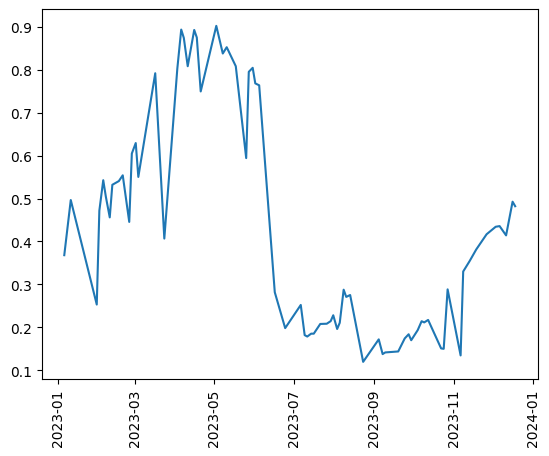

In [21]:
median_ndvis = []
for t in time_values:
    ndvi_t = xx.sel(time=t)['ndvi']
    median_ndvi_t = ndvi_t.median(dim=['latitude', 'longitude'], skipna=True)
    median_ndvis.append(median_ndvi_t)
    
plt.plot(time_values, median_ndvis)
ax = plt.xticks(rotation=90)

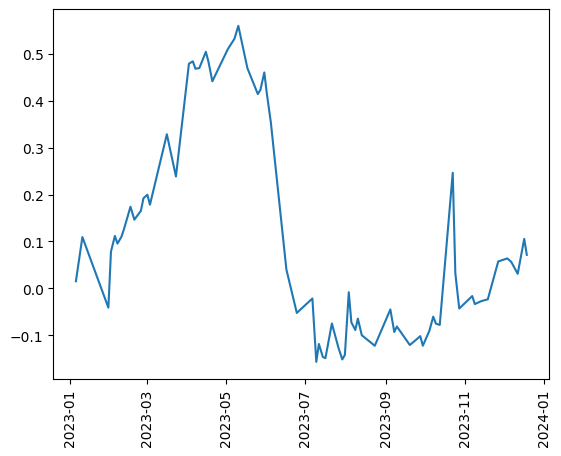

In [22]:
median_ndmis = []
for t in time_values:
    ndmi_t = xx.sel(time=t)['ndmi']
    median_ndmi_t = ndmi_t.median(dim=['latitude', 'longitude'], skipna=True)
    median_ndmis.append(median_ndmi_t)
    
plt.plot(time_values, median_ndmis)
ax = plt.xticks(rotation=90)

In [23]:
xx_median_ndvi_min = xx.sel(time=min(median_ndvis).time)
xx_median_ndvi_max = xx.sel(time=max(median_ndvis).time)

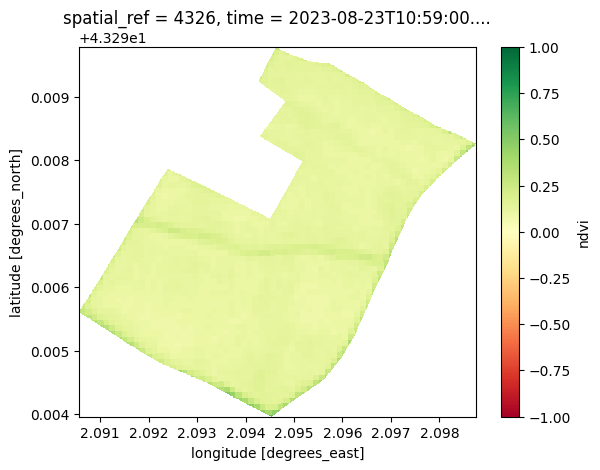

In [24]:
xx_median_ndvi_min.ndvi.plot(vmin=-1, vmax=1, cmap="RdYlGn")

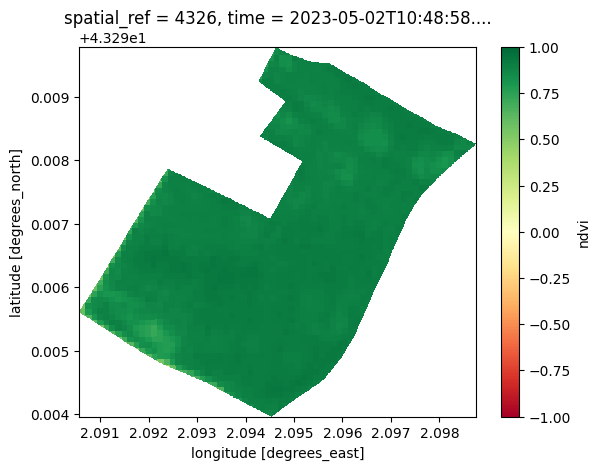

In [25]:
xx_median_ndvi_max.ndvi.plot(vmin=-1, vmax=1, cmap="RdYlGn")

In [26]:
xx_median_ndmi_min = xx.sel(time=min(median_ndmis).time)
xx_median_ndmi_max = xx.sel(time=max(median_ndmis).time)

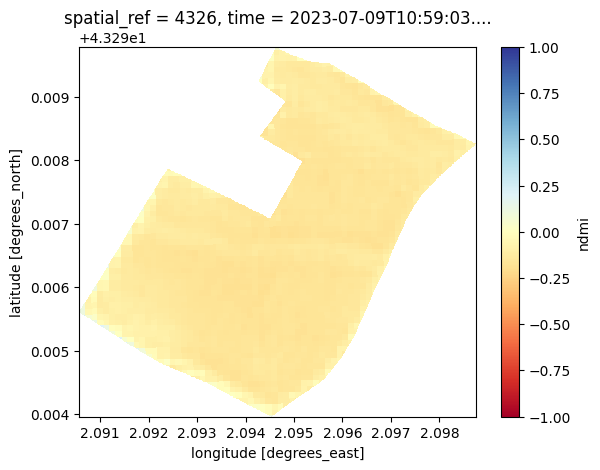

In [27]:
xx_median_ndmi_min.ndmi.plot(vmin=-1, vmax=1, cmap="RdYlBu")

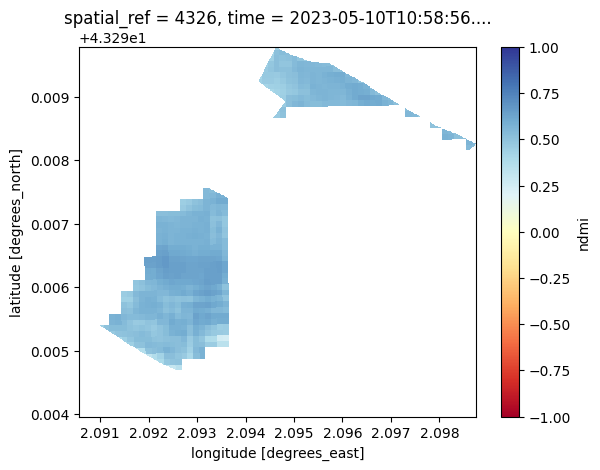

In [28]:
xx_median_ndmi_max.ndmi.plot(vmin=-1, vmax=1, cmap="RdYlBu")